# Import libraries

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, make_scorer, fbeta_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline
import shap

import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)

# Load Data

In [2]:
data = pd.read_excel('BCTC_2015_2023.xlsx')
inflation_data = pd.read_excel('PhiTaiChinh.xlsx', sheet_name='Lạm phát')
GDP_data = pd.read_excel('PhiTaiChinh.xlsx', sheet_name='GDP')

# Check data and merger data

In [3]:
df = data.copy()

In [4]:
print(f"Dữ liệu BCTC: {df.shape}")
print(f"Dữ liệu tỷ lệ lạm phát: {inflation_data.shape}")
print(f"Dữ liệu tăng trưởng GDP: {GDP_data.shape}")

Dữ liệu BCTC: (9711, 203)
Dữ liệu tỷ lệ lạm phát: (9, 3)
Dữ liệu tăng trưởng GDP: (9, 3)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9711 entries, 0 to 9710
Columns: 203 entries, STT to EBITDA 
Chỉ số năm
Năm: 2015
Đơn vị: VND
dtypes: float64(198), int64(2), object(3)
memory usage: 15.0+ MB


In [6]:
inflation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Năm             9 non-null      int64  
 1   Tỷ lệ (%)       9 non-null      float64
 2   Inflation_rate  9 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 344.0 bytes


In [7]:
GDP_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Năm        9 non-null      int64  
 1   Tỷ lệ (%)  9 non-null      float64
 2   GDP rate   9 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 344.0 bytes


In [8]:
# Nối thêm dữ liệu lạm phát và GDP vào dataframe chính
df = df.merge(inflation_data[['Năm', 'Inflation_rate']], left_on='Year', right_on='Năm', how='left')
df = df.merge(GDP_data[['Năm', 'GDP rate']], left_on='Year', right_on='Năm', how='left')

In [9]:
df.head()

,STT,Mã,Sàn,Phân ngành - ICB L1,Year,I. TÀI SẢN NGẮN HẠN\nHợp nhất\nQuý: Hàng năm\nNăm: 2015\nĐơn vị: VND,1. Tiền và tương đương tiền \nHợp nhất\nQuý: Hàng năm\nNăm: 2015\nĐơn vị: VND,1.1. Tiền\nHợp nhất\nQuý: Hàng năm\nNăm: 2015\nĐơn vị: VND,1.2. Các khoản tương đương tiền\nHợp nhất\nQuý: Hàng năm\nNăm: 2015\nĐơn vị: VND,2. Đầu tư tài chính ngắn hạn\nHợp nhất\nQuý: Hàng năm\nNăm: 2015\nĐơn vị: VND,...,(LNST - CFO)/ Doanh thu \nChỉ số năm\nNăm: 2015\nĐơn vị: Lần,Doanh thu tính trên đầu người\nChỉ số năm\nNăm: 2015\nĐơn vị: VND,EBITDA/ (Nợ vay ngắn hạn + lãi vay)\nChỉ số năm\nNăm: 2015\nĐơn vị: Lần,EBITDA/ Lãi vay\nChỉ số năm\nNăm: 2015\nĐơn vị: Lần,EBIT \nChỉ số năm\nNăm: 2015\nĐơn vị: VND,EBITDA \nChỉ số năm\nNăm: 2015\nĐơn vị: VND,Năm_x,Inflation_rate,Năm_y,GDP rate
0,1,AAA,HOSE,Nguyên vật liệu,2015,1071561008455.00,470061718120.00,242393182850.00,227668535270.00,0.00,...,0.07,NaN,0.34,6.50,72969330290.00,156327615384.00,2015,0.01,2015,0.07
1,2,AAM,HOSE,Hàng Tiêu dùng,2015,270531281331.00,27955052472.00,27955052472.00,0.00,74711410174.00,...,0.01,NaN,0.10,4.81,-1330080278.00,5028081154.00,2015,0.01,2015,0.07
2,3,AAT,HOSE,Hàng Tiêu dùng,2015,158278885123.00,2596627141.00,2596627141.00,0.00,0.00,...,0.19,NaN,0.55,12.11,4731723391.00,33525300166.00,2015,0.01,2015,0.07
3,4,ABR,HOSE,Công nghiệp,2015,19423201917.00,845529654.00,845529654.00,0.00,0.00,...,0.31,279577335.17,49.12,49.12,1205413086.00,1263085464.00,2015,0.01,2015,0.07
4,6,ABT,HOSE,Hàng Tiêu dùng,2015,499743419677.00,263770933903.00,33770933903.00,230000000000.00,217151855.00,...,-0.13,802041930.41,0.64,27.71,81841125391.00,88843765689.00,2015,0.01,2015,0.07


# Data Cleaning

In [10]:
# Loại bỏ các cột 'Năm_x' và 'Năm_y' không cần thiết
df.drop(columns=['Năm_x', 'Năm_y'], inplace=True)

In [11]:
# Xóa các ký tự thừa trong tên cột
df.columns = df.columns.str.replace(f"\nChỉ số năm\nNăm: 2015\nĐơn vị: .*", '', regex=True)
df.columns = df.columns.str.replace(f'\nHợp nhất\nQuý: Hàng năm\nNăm: 2015\nĐơn vị: VND.*', '', regex=True)
df.columns = df.columns.str.replace(f'\nNgày: 31/12/2015\nĐơn vị:', '', regex=True)
df.columns = df.columns.str.strip()

In [12]:
df.columns.to_list()

['STT',
 'Mã',
 'Sàn',
 'Phân ngành - ICB L1',
 'Year',
 'I. TÀI SẢN NGẮN HẠN',
 '1. Tiền và tương đương tiền',
 '1.1. Tiền',
 '1.2. Các khoản tương đương tiền',
 '2. Đầu tư tài chính ngắn hạn',
 '2.1. Chứng khoán kinh doanh',
 '2.2. Dự phòng giảm giá chứng khoán kinh doanh',
 '2.3. Đầu tư nắm giữ đến ngày đáo hạn',
 '3. Các khoản phải thu ngắn hạn',
 '3.1. Phải thu ngắn hạn của khách hàng',
 '3.2. Trả trước cho người bán ngắn hạn',
 '3.3. Phải thu nội bộ ngắn hạn',
 '3.4. Phải thu theo tiến độ kế hoạch hợp đồng xây dựng',
 '3.5. Phải thu về cho vay ngắn hạn',
 '3.6. Phải thu ngắn hạn khác',
 '3.7. Dự phòng phải thu ngắn hạn khó đòi',
 '3.8. Tài sản thiếu chờ xử lý',
 '4. Hàng tồn kho, ròng',
 '4.1. Hàng tồn kho',
 '4.2. Dự phòng giảm giá HTK',
 '5. Tài sản ngắn hạn khác',
 '5.1. Chi phí trả trước ngắn hạn',
 '5.2. Thuế GTGT được khấu trừ',
 '5.3. Thuế và các khoản khác phải thu Nhà nước',
 '5.4. Giao dịch mua bán lại trái phiếu chính phủ',
 '5.5. Tài sản ngắn hạn khác',
 'II. TÀI SẢN 

In [13]:
# Kiểm tra dữ liệu có những phân ngành nào và số lượng công ty trong mỗi phân ngành
df['Phân ngành - ICB L1'].value_counts()

Phân ngành - ICB L1
Công nghiệp        5526
Hàng Tiêu dùng     2223
Nguyên vật liệu    1719
Ngân hàng           243
Name: count, dtype: int64

Tiêu chí đầu tiên là các công ty thuộc lĩnh vực tài chính/bảo hiểm/ngân hàng sẽ bị loại khỏi mẫu nghiên cứu vì cơ cấu bảng cân đối kế toán của các công ty này khác với cấu trúc của các ngành khác và nhóm chỉ tập trung vào ngành sản xuất.

In [14]:
df = df[df['Phân ngành - ICB L1'] != 'Ngân hàng']

Tiêu chí thứ hai, công ty lựa chọn phải niêm yết ít nhất ba năm tính đến 2023

In [15]:
# Đếm số năm xuất hiện của mỗi công ty
year_count = df.groupby(by='Mã')['Year'].nunique().reset_index(name='Count')

# Lọc ra các công ty niêm yết trên 3 năm và dưới 3 năm
companies_over_3_years = year_count[year_count['Count'] >= 3]
companies_under_3_years = year_count[year_count['Count'] < 3]

# Đếm số lượng công ty ở mỗi nhóm
num_over_3 = len(companies_over_3_years)
num_under_3 = len(companies_under_3_years)

print(f"Số công ty niêm yết trên 3 năm: {num_over_3}")
print(f"Số công ty niêm yết dưới hoặc bằng 3 năm: {num_under_3}")

Số công ty niêm yết trên 3 năm: 1052
Số công ty niêm yết dưới hoặc bằng 3 năm: 0


Sau khi lọc xong dữ liệu, nhóm bắt đầu tính các chỉ số tài chính để phục vụ cho phân tích theo nhóm chỉ số tài chính và huấn luyện mô hình học máy

In [16]:
new_df = pd.DataFrame()

# Tên các cột đã có
new_df['Mã'] = df['Mã']
new_df['Year'] = df['Year']
new_df['Inflation_rate'] = df['Inflation_rate']
new_df['GDP rate'] = df['GDP rate']
# new_df['Phân ngành - ICB L1'] = df['Phân ngành - ICB L1']

# Tỷ suất khả năng thanh toán lãi vay (Interest Coverage Ratio - ICR)
new_df['ICR'] = df['EBIT'] / df['7.1. Trong đó: Chi phí lãi vay']

# Tỷ suất sinh lời
# Tỷ suất sinh lời trước thuế và lãi vay trên tổng tài sản (Return on Assets - ROA_EBIT)
new_df['EBITTA'] = df['EBIT'] / df['A. TỔNG CỘNG TÀI SẢN']

# Tỷ suất sinh lời trên tổng tài sản (Return on Assets - ROA)
new_df['ROA'] = df['18. Lợi nhuận sau thuế thu nhập doanh nghiệp'] / df['A. TỔNG CỘNG TÀI SẢN']

# Vòng quay tổng tài sản (Total Asset Turnover - TAT)
new_df['TAT'] = df['1. Doanh thu bán hàng và cung cấp dịch vụ']/ df['A. TỔNG CỘNG TÀI SẢN']

# new_df['NITS'] = df['18. Lợi nhuận sau thuế thu nhập doanh nghiệp'] / df['1. Doanh thu bán hàng và cung cấp dịch vụ']
# new_df['EBITDATL'] = df['EBITDA'] / df['I. NỢ PHẢI TRẢ']
# new_df['EBITDATA'] = df['EBITDA'] / df['A. TỔNG CỘNG TÀI SẢN']
# new_df['EBITTS'] = df['EBIT'] / df['1. Doanh thu bán hàng và cung cấp dịch vụ']

# Tỷ lệ thanh khoản 
# Tỷ lệ Nợ ngắn hạn trên Tổng tài sản (Current Liabilities to Total Assets - CLTA)
new_df['CLTA'] = df['1. Nợ ngắn hạn'] / df['A. TỔNG CỘNG TÀI SẢN']

# Tỷ lệ Tổng tài sản ngắn hạn trên Tổng nợ (Current Assets to Total Liabilities - CATL)
new_df['CATL'] = df['I. TÀI SẢN NGẮN HẠN'] / df['I. NỢ PHẢI TRẢ']

# Tỷ lệ Nợ ngắn hạn trên Doanh thu (Current Liabilities to Sales - CLTS)
new_df['CLTS'] = df['1. Nợ ngắn hạn'] / df['1. Doanh thu bán hàng và cung cấp dịch vụ']

# Tỷ lệ Nợ ngắn hạn trên Tổng nợ (Current Liabilities to Total Liabilities - CLTL)
new_df['CLTL'] = df['1. Nợ ngắn hạn'] / df['I. NỢ PHẢI TRẢ']

# Tỷ lệ Hàng tồn kho trên Tổng tài sản (Inventory to Total Assets - ITA)
new_df['ITA'] = df['4.1. Hàng tồn kho'] / df['A. TỔNG CỘNG TÀI SẢN']

# new_df['CACL'] = df['I. TÀI SẢN NGẮN HẠN'] / df['1. Nợ ngắn hạn']
# new_df['CTA'] = df['1. Tiền và tương đương tiền'] / df['A. TỔNG CỘNG TÀI SẢN']
# new_df['CCATL'] = df['1. Tiền và tương đương tiền'] / df['I. TÀI SẢN NGẮN HẠN']

# Đòn bẩy
# Tỷ lệ Tổng nợ trên Tổng tài sản (Debt to Assets Ratio - D/A)
new_df['DA'] = df['I. NỢ PHẢI TRẢ'] / df['A. TỔNG CỘNG TÀI SẢN']

# Tỷ lệ Thanh toán tiền mặt (Cash Ratio - Cash/CL)
new_df['CCL'] = df['1. Tiền và tương đương tiền'] / df['1. Nợ ngắn hạn']

# Tỷ lệ tăng trưởng
new_df['GTA'] = df['Tăng trưởng tổng tài sản (YoY) (Quý, Năm)']
new_df['GNR'] = df['Tăng trưởng doanh thu thuần (YoY) (Quý, Năm)']

# Thu nhập ròng (NI) = Tổng doanh thu - Tổng chi phí
# Lợi nhuận sau thuế = Tổng doanh thu – Tổng chi phí – Thuế thu nhập doanh nghiệp

Sau khi tính xong các chỉ số, nhóm tiến hành kiểm tra giá trị trùng lặp

In [17]:
print(new_df.duplicated().sum())
new_df[new_df.duplicated(keep=False)]

0


,Mã,Year,Inflation_rate,GDP rate,ICR,EBITTA,ROA,TAT,CLTA,CATL,CLTS,CLTL,ITA,DA,CCL,GTA,GNR


**Kiểm tra giá trị thiếu**

In [18]:
# Kiểm tra missing value
def check_missing_value(df):
    missing_value = df.isnull().sum()
    missing_value = missing_value[missing_value > 0]
    if missing_value.empty:
        print("Không có missing values")
    else:
        missing_value = missing_value.sort_values(ascending=False)
        print("Các cột có missing value:")
        print(missing_value)

check_missing_value(new_df)

Các cột có missing value:
ICR       824
EBITTA    824
ROA       813
TAT       813
CLTS      813
CLTA      792
CATL      792
CLTL      792
ITA       792
DA        792
CCL       792
GTA       787
GNR       787
dtype: int64


In [19]:
new_df[np.isnan(new_df['ICR'])]

,Mã,Year,Inflation_rate,GDP rate,ICR,EBITTA,ROA,TAT,CLTA,CATL,CLTS,CLTL,ITA,DA,CCL,GTA,GNR
7,ACG,2015,0.01,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,APH,2015,0.01,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,ASG,2015,0.01,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,ATP,2015,0.01,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,BAF,2015,0.01,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9669,VLF,2023,0.03,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9680,VPC,2023,0.03,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9697,VW1,2023,0.03,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9699,VXB,2023,0.03,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sau khi kiểm tra dữ liệu thì các dòng có giá trị thiếu thì hầu như tất cả các cột khác cũng có giá trị thiếu nên nhóm tiến hành loại bỏ những dòng này

In [20]:
# Xóa các giá trị vô hạn và missing value
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_df.dropna(inplace=True)

In [21]:
check_missing_value(new_df)

Không có missing values


In [22]:
new_df.to_csv('financial_ratios_data.csv', index=False)

Sau khi loại bỏ các giá trị thiếu thì nhóm tiến hành loại bỏ những dòng dữ liệu theo năm không liên tiếp nhau

In [23]:
# Sắp xếp dữ liệu theo đúng thứ tự
new_df = new_df.sort_values(['Mã', 'Year']).reset_index(drop=True)

# đánh dấu các hàng mà hàng kế tiếp cùng mã có Year = Year + 1
new_df['has_next_year'] = (new_df.groupby('Mã')['Year']
                               .transform(lambda x: (x.shift(-1) - x) == 1))

# lọc theo điều kiện logic
def filter_true_sequences(group):
    cond = (group['has_next_year']) | (group['has_next_year'].shift(1).fillna(False))
    return group[cond]

df_filtered = new_df.groupby('Mã', group_keys=False).apply(filter_true_sequences)

print("Số dòng trước khi lọc:", new_df.shape[0])
print("Số dòng sau khi lọc:", df_filtered.shape[0])

# Loại bỏ cột 'has_next_year' sau khi lọc
df_filtered.drop(columns=['has_next_year'], inplace=True)

Số dòng trước khi lọc: 7333
Số dòng sau khi lọc: 7192


In [24]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7192 entries, 0 to 7332
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mã              7192 non-null   object 
 1   Year            7192 non-null   int64  
 2   Inflation_rate  7192 non-null   float64
 3   GDP rate        7192 non-null   float64
 4   ICR             7192 non-null   float64
 5   EBITTA          7192 non-null   float64
 6   ROA             7192 non-null   float64
 7   TAT             7192 non-null   float64
 8   CLTA            7192 non-null   float64
 9   CATL            7192 non-null   float64
 10  CLTS            7192 non-null   float64
 11  CLTL            7192 non-null   float64
 12  ITA             7192 non-null   float64
 13  DA              7192 non-null   float64
 14  CCL             7192 non-null   float64
 15  GTA             7192 non-null   float64
 16  GNR             7192 non-null   float64
dtypes: float64(15), int64(1), object(1)
me

In [25]:
df_filtered

,Mã,Year,Inflation_rate,GDP rate,ICR,EBITTA,ROA,TAT,CLTA,CATL,CLTS,CLTL,ITA,DA,CCL,GTA,GNR
0,AAA,2015,0.01,0.07,-3.03,0.04,0.02,0.83,0.34,0.94,0.41,0.59,0.11,0.58,0.70,0.38,0.03
1,AAA,2016,0.03,0.07,-6.87,0.06,0.05,0.70,0.37,0.64,0.53,0.54,0.15,0.69,0.36,0.57,0.33
2,AAA,2017,0.04,0.07,-4.53,0.08,0.06,0.89,0.44,0.73,0.49,0.67,0.12,0.64,0.26,0.49,0.90
3,AAA,2018,0.04,0.07,-3.12,0.05,0.03,1.07,0.43,0.88,0.40,0.70,0.11,0.60,0.20,0.65,0.97
4,AAA,2019,0.03,0.07,-3.01,0.08,0.06,1.16,0.41,1.05,0.35,0.68,0.15,0.59,0.09,0.06,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7328,YBM,2019,0.03,0.07,-1.53,0.07,0.02,0.95,0.51,0.79,0.54,0.78,0.18,0.65,0.02,-0.06,0.36
7329,YBM,2020,0.03,0.03,-2.38,0.09,0.03,1.02,0.47,0.85,0.47,0.80,0.13,0.59,0.09,-0.09,-0.02
7330,YBM,2021,0.02,0.03,-2.29,0.07,0.03,1.13,0.48,0.84,0.42,0.81,0.07,0.59,0.04,0.04,0.16
7331,YBM,2022,0.03,0.08,-1.84,0.06,0.02,1.05,0.47,0.87,0.45,0.83,0.16,0.57,0.10,-0.06,-0.13


In [26]:
# Tạo cột Target bằng cách dịch chuyển cột ICR lên một hàng trong mỗi nhóm Mã
df_filtered['Target'] = df_filtered.groupby('Mã')['ICR'].shift(-1)

In [27]:
# Xóa các hàng có giá trị bị thiếu sau khi tạo biến mục tiêu
df_filtered.dropna(inplace=True)
# Bỏ cột ICR 
df_filtered.drop(columns='ICR', inplace=True)

In [28]:
# Chuyển biến mục tiêu thành bài toán phân lớp
df_filtered['Target'] = (df_filtered['Target'] >= 1).astype(int)

# EDA

In [28]:
df_filtered.describe()

,Year,Inflation_rate,GDP rate,EBITTA,ROA,TAT,CLTA,CATL,CLTS,CLTL,ITA,DA,CCL,GTA,GNR,Target
count,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00,6249.00
mean,2018.48,0.03,0.06,0.05,0.03,1.20,0.58,1.62,6.57,0.83,0.21,0.69,0.30,0.11,0.25,0.12
std,2.28,0.01,0.02,0.12,0.20,1.21,1.79,12.58,367.53,0.21,0.17,1.83,2.86,1.16,3.11,0.32
min,2015.00,0.01,0.03,-5.60,-8.04,-0.05,0.00,0.00,-8.81,0.03,0.00,0.00,0.00,-0.97,-3.24,0.00
25%,2016.00,0.03,0.07,0.02,0.01,0.53,0.28,0.76,0.26,0.73,0.07,0.38,0.03,-0.06,-0.11,0.00
50%,2018.00,0.03,0.07,0.05,0.03,0.96,0.46,1.09,0.44,0.93,0.18,0.58,0.10,0.02,0.04,0.00
75%,2020.00,0.04,0.07,0.09,0.07,1.51,0.64,1.52,0.78,0.99,0.31,0.74,0.26,0.15,0.21,0.00
max,2022.00,0.04,0.08,0.81,0.90,21.69,79.21,982.49,29003.73,1.00,2.47,79.28,219.83,82.25,127.46,1.00


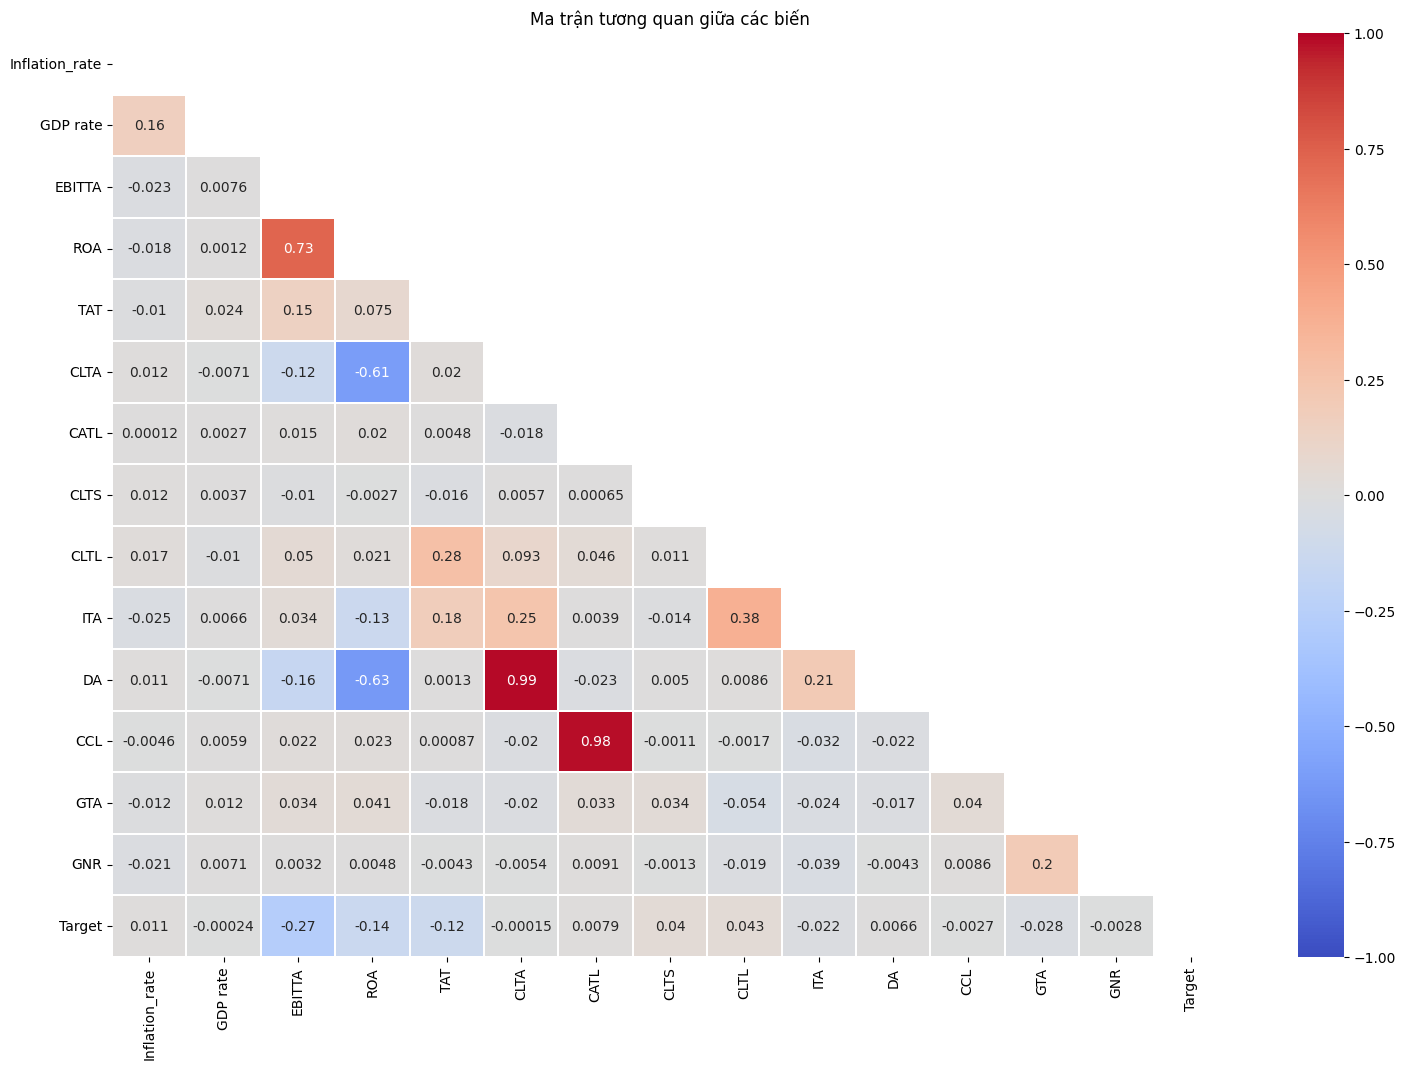

In [29]:
temp = df_filtered.drop(columns=['Mã', 'Year'])

plt.figure(figsize=(18, 12))
corr = temp.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
        corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        linewidths=.2,
        cmap='coolwarm',
        vmin=-1,
        vmax=1
    )
plt.title('Ma trận tương quan giữa các biến')
plt.show()

In [30]:
# Kiểm tra sự phân bố của biến mục tiêu
df_filtered['Target'].value_counts()

Target
0    5516
1     733
Name: count, dtype: int64

# Build Model

## Split train/test set

In [29]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train = df_filtered[df_filtered['Year'] <= 2020].drop(columns=['Mã', 'Year', 'Target'])
y_train = df_filtered[df_filtered['Year'] <= 2020]['Target']

X_test = df_filtered[df_filtered['Year'] >= 2021].drop(columns=['Mã', 'Year', 'Target'])
y_test = df_filtered[df_filtered['Year'] >= 2021]['Target']

In [30]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4726, 14), (4726,), (1523, 14), (1523,))

## Data Preprocessing

- Chuẩn hóa cho các biến số học: Đối với các biến tenure và MonthlyCharges, ta sử dụng StandardScaler để chuẩn hóa dữ liệu.
 Việc này giúp các đặc trưng số có cùng thang đo (mean = 0, std = 1), đảm bảo rằng mọi biến đều đóng góp công bằng cho mô hình học máy.

In [31]:
cols = X_train.columns.tolist()
scaling_transformer = Pipeline(steps=[
    ('standard', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('scaling', scaling_transformer, cols)
    ],
    remainder='passthrough'
)

## **Model Benchmarking: Classification Algorithms**
Phần này sẽ đánh giá nhiều thuật toán phân loại khác nhau để xác định mô hình tốt nhất cho việc dự đoán công ty có rơi vào tình trạng kiệt quệ tài chính trong năm tiếp theo không. Mỗi mô hình trước tiên sẽ được huấn luyện và xác thực bằng phương pháp cross-validation, với recall được sử dụng làm chỉ số đánh giá chính trong quá trình huấn luyện. Sau khi huấn luyện, các mô hình sẽ được kiểm tra trên một tập dữ liệu kiểm thử riêng biệt, và hiệu suất của chúng được đo lường bằng các chỉ số như F1 score, accuracy, precision, và recall. Kết quả từ các mô hình khác nhau này sau đó sẽ được so sánh để xác định mô hình hiệu quả nhất cho bộ dữ liệu này.

In [34]:
clf_models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('MLP', MLPClassifier(random_state=42))
]

results = []
for model_name, model in clf_models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    print(f"{model_name} training...")
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Train recall': score.mean(),
        'Train recall std': score.std(),
        'Test Accuracy': accuracy,
        'Test Precision': precision,
        'Test Recall': recall,
        'Test F1-Score': f1,
        'Test ROC-AUC': roc_auc
    })

Logistic Regression training...
Random Forest training...
XGBoost training...
Support Vector Machine training...
MLP training...


In [35]:
results_df = pd.DataFrame(results).sort_values(by='Test Recall', ascending=False)
results_df

,Model,Train recall,Train recall std,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test ROC-AUC
4,MLP,0.26,0.03,0.87,0.55,0.33,0.41,0.64
2,XGBoost,0.26,0.04,0.87,0.56,0.31,0.40,0.63
1,Random Forest,0.21,0.08,0.88,0.70,0.30,0.42,0.64
0,Logistic Regression,0.16,0.04,0.87,0.75,0.15,0.25,0.57
3,Support Vector Machine,0.02,0.01,0.86,1.00,0.01,0.03,0.51


**Diễn giải kết quả đánh giá mô hình trong các thuật toán phân loại**

Dựa trên kết quả đánh giá trên cả tập train và test, có thể thấy rằng 3 thuật toán phân loại hoạt động ổn định và hiệu quả nhất là XGBoost, Random Forest và MLP. Do đó, 3 mô hình này sẽ được sử dụng trong giai đoạn lựa chọn mô hình tiếp theo, nơi các kỹ thuật resampling sẽ được áp dụng.

## **Model Benchmarking with Resampling Techniques**

Quy trình này bao gồm việc đánh giá nhiều thuật toán phân loại khác nhau cùng với các phương pháp resampling nhằm xử lý vấn đề mất cân bằng lớp và cải thiện hiệu suất của mô hình.
3 mô hình được sử dụng từ giai đoạn trước gồm: XGBoost, Random Forest và MLP, được huấn luyện và đánh giá bằng cross-validation, với recall là chỉ số đánh giá chính trong quá trình huấn luyện.
Sau khi mô hình được huấn luyện, hiệu suất của chúng được đo lường trên tập test bằng các chỉ số F1 score, accuracy, precision, và recall.

Các kỹ thuật lấy mẫu lại được sử dụng bao gồm:

- None: Không áp dụng kỹ thuật lấy mẫu lại (làm chuẩn so sánh).

- RandomOverSampler: Tăng số lượng mẫu của lớp thiểu số một cách ngẫu nhiên để cân bằng phân bố lớp.

- SMOTE (Synthetic Minority Over-sampling Technique): Tạo thêm các mẫu giả lập cho lớp thiểu số bằng cách nội suy giữa các mẫu hiện có.

- SMOTEENN: Kết hợp giữa SMOTE và Edited Nearest Neighbors (ENN) — đầu tiên tăng mẫu của lớp thiểu số, sau đó loại bỏ các mẫu nhiễu để làm sạch dữ liệu.

In [36]:
clf_models = [
    ('MLP', MLPClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

resamplers = [
    ('None', None),
    ('RandomOverSampler', RandomOverSampler(random_state=42)),
    ('SMOTE', SMOTE(random_state=42)),
    # ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
    ('SMOTEENN', SMOTEENN(random_state=42))
]

results = []
for resampler_name, resampler in resamplers:
    for model_name, model in clf_models:
        print(f"Resampling method: {resampler_name} - Model: {model_name}")
        
        steps = [('preprocessor', preprocessor)]
        if resampler is not None:
            steps.append(('resampler', resampler))
        steps.append(('classifier', model))
        pipeline = Pipeline(steps=steps)
        
        score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # Type I & II errors
        type_I_error = fp / (fp + tn) if (fp + tn) > 0 else 0
        type_II_error = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        results.append({
            'Model': model_name,
            'Resampler': resampler_name,
            'Train Recall': score.mean(),
            'Train Recall std': score.std(),
            'Test Accuracy': accuracy,
            'Test Precision': precision,
            'Test Recall': recall,
            'Test F1-Score': f1,
            'Test ROC-AUC': roc_auc,
            'Type I Error': type_I_error,
            'Type II Error': type_II_error
        })

Resampling method: None - Model: MLP
Resampling method: None - Model: Random Forest
Resampling method: None - Model: XGBoost
Resampling method: RandomOverSampler - Model: MLP
Resampling method: RandomOverSampler - Model: Random Forest
Resampling method: RandomOverSampler - Model: XGBoost
Resampling method: SMOTE - Model: MLP
Resampling method: SMOTE - Model: Random Forest
Resampling method: SMOTE - Model: XGBoost
Resampling method: SMOTEENN - Model: MLP
Resampling method: SMOTEENN - Model: Random Forest
Resampling method: SMOTEENN - Model: XGBoost


In [37]:
results_df = pd.DataFrame(results).sort_values(by=['Test Recall'], ascending=False)
results_df

,Model,Resampler,Train Recall,Train Recall std,Test Accuracy,Test Precision,Test Recall,Test F1-Score,Test ROC-AUC,Type I Error,Type II Error
3,MLP,RandomOverSampler,0.64,0.04,0.63,0.24,0.74,0.36,0.67,0.39,0.26
10,Random Forest,SMOTEENN,0.75,0.03,0.80,0.38,0.70,0.50,0.76,0.19,0.30
11,XGBoost,SMOTEENN,0.69,0.04,0.77,0.34,0.69,0.46,0.74,0.22,0.31
6,MLP,SMOTE,0.63,0.03,0.73,0.29,0.66,0.41,0.70,0.26,0.34
9,MLP,SMOTEENN,0.75,0.02,0.79,0.37,0.66,0.47,0.74,0.18,0.34
8,XGBoost,SMOTE,0.46,0.07,0.80,0.37,0.64,0.47,0.73,0.18,0.36
7,Random Forest,SMOTE,0.55,0.07,0.86,0.50,0.59,0.54,0.75,0.10,0.41
5,XGBoost,RandomOverSampler,0.37,0.05,0.87,0.55,0.44,0.49,0.69,0.06,0.56
4,Random Forest,RandomOverSampler,0.31,0.06,0.88,0.63,0.39,0.48,0.68,0.04,0.61
0,MLP,None,0.26,0.03,0.87,0.55,0.33,0.41,0.64,0.05,0.67


**Diễn giải kết quả**

Dựa trên kết quả thu được, có thể thấy rằng mô hình hoạt động ổn định và hiệu quả nhất là Random Forest kết hợp với kỹ thuật SMOTEENN.
Sự kết hợp này đạt được recall trên tập test là 0.70 và recall trung bình trên tập huấn luyện là 0.75, thể hiện hiệu suất tốt trên cả hai tập dữ liệu.

Giá trị recall của tập test và train khá gần nhau, cho thấy mô hình tổng quát hóa tốt (không bị overfitting).
Recall cao trên tập kiểm thử cũng chỉ ra rằng mô hình rất hiệu quả trong việc nhận diện đúng các trường hợp dương tính (Doanh nghiệp có khả năng kiệt quệ tài chính vào năm tiếp theo), do đó đây là một lựa chọn đáng tin cậy cho bài toán dự đoán này.

## Tuning Hyperparameters

### Before tuning

In [38]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
]

Init_model = Pipeline(steps=steps)
Init_model.fit(X_train, y_train)
y_pred_init = Init_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_init)
tn, fp, fn, tp = cm.ravel()

init_metrics = {
    'Recall' : recall_score(y_test, y_pred_init),
    'Precision' : precision_score(y_test, y_pred_init),
    'F1-Score' : f1_score(y_test, y_pred_init),
    'Accuracy' : accuracy_score(y_test, y_pred_init),
    'ROC-AUC' : roc_auc_score(y_test, y_pred_init),
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp
}

rf_params = Init_model.named_steps['classifier'].get_params()
print(f"Random Forest initial parameters:\n{ {key: rf_params[key] for key in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']} }")

init_metrics_results = pd.DataFrame([init_metrics])
init_metrics_results

Random Forest initial parameters:
{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


,Recall,Precision,F1-Score,Accuracy,ROC-AUC,TN,FP,FN,TP
0,0.70,0.38,0.50,0.80,0.76,1061,246,64,152


### After tuning

In [42]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
]

pipeline = Pipeline(steps=steps)

# --- Lưới tham số ---
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# --- GridSearchCV ---
grid_search_rf = GridSearchCV(
    pipeline,
    param_grid=param_grid_rf,
    scoring='recall', 
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

# --- Kết quả ---
print("Best params:", grid_search_rf.best_params_)
print("Best CV Recall:", round(grid_search_rf.best_score_, 4))

# --- Mô hình tốt nhất ---
best_rf_model = grid_search_rf.best_estimator_

# --- Dự đoán trên tập test ---
y_pred_rf = best_rf_model.predict(X_test)

# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()

# --- Đánh giá ---
metrics_rf = {
    'Recall': round(recall_score(y_test, y_pred_rf), 4),
    'Precision': round(precision_score(y_test, y_pred_rf), 4),
    'F1-Score': round(f1_score(y_test, y_pred_rf), 4),
    'Accuracy': round(accuracy_score(y_test, y_pred_rf), 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_pred_rf), 4),
    'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
}

metrics_results_rf = pd.DataFrame([metrics_rf])
print("\nHiệu suất mô hình Random Forest tốt nhất:")
print(metrics_results_rf)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best params: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV Recall: 0.8182

Hiệu suất mô hình Random Forest tốt nhất:
   Recall  Precision  F1-Score  Accuracy  ROC-AUC   TN   FP  FN   TP
0    0.76       0.33      0.46      0.75     0.75  975  332  51  165


In [45]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
]

pipeline = Pipeline(steps=steps)

# --- Lưới tham số ---
param_grid_rf = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [2],
    'classifier__min_samples_leaf': [1],
    'classifier__max_features': ['sqrt']
}

# --- GridSearchCV ---
grid_search_rf = GridSearchCV(
    pipeline,
    param_grid=param_grid_rf,
    scoring=make_scorer(fbeta_score, beta=2),
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

# --- Kết quả ---
print("Best params:", grid_search_rf.best_params_)
print("Best CV F2 score:", grid_search_rf.best_score_)

# --- Mô hình tốt nhất ---
best_rf_model = grid_search_rf.best_estimator_

# --- Dự đoán trên tập test ---
y_pred_rf = best_rf_model.predict(X_test)

# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cm.ravel()

# --- Đánh giá ---
metrics_rf = {
    'Recall': recall_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_rf),
    'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
}

metrics_results_rf = pd.DataFrame([metrics_rf])
print("\nHiệu suất mô hình Random Forest tốt nhất:")
print(metrics_results_rf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best params: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV F2 score: 0.6102661267771792

Hiệu suất mô hình Random Forest tốt nhất:
   Recall  Precision  F1-Score  Accuracy  ROC-AUC   TN   FP  FN   TP
0    0.76       0.33      0.46      0.75     0.75  975  332  51  165


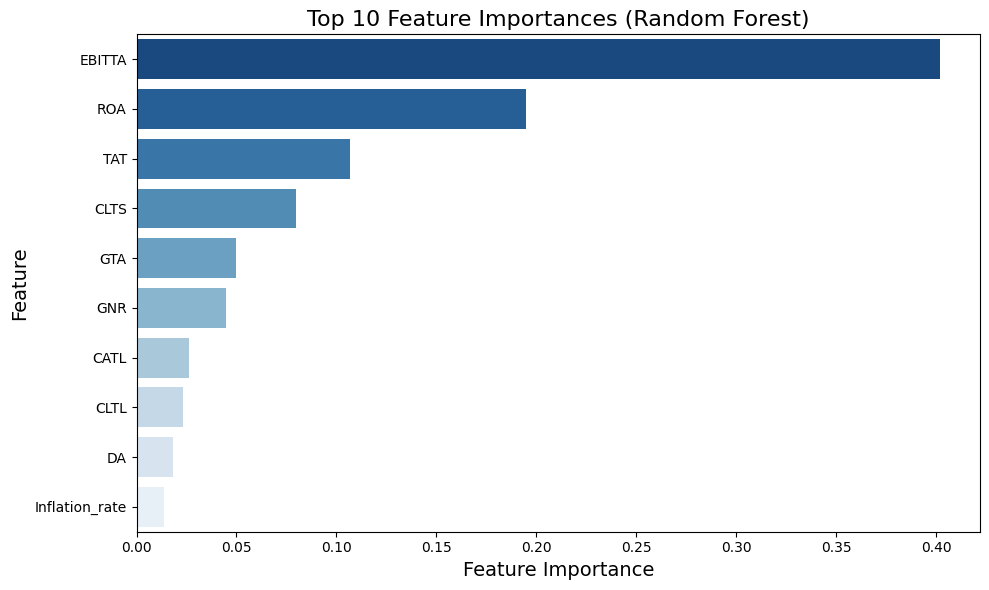

In [41]:
# Retrieve the best classifier from the pipeline
best_model = best_rf_model
best_clf = best_rf_model.named_steps['classifier']

# Lấy feature importances thay vì coefficients
importances = best_clf.feature_importances_

# Lấy tên biến từ preprocessor
feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()
feature_names = [name.replace("scaling__", "") for name in feature_names]
# Kết hợp
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Vẽ
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance.head(10),
    x="Importance", y="Feature",
    palette="Blues_r"
)
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=16)
plt.xlabel("Feature Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
feature_names = X_train.columns

# Áp dụng SMOTEENN trên tập train
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features='sqrt',random_state=42)
# model = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.01, reg_alpha=0, reg_lambda = 1, random_state=42)
model.fit(X_resampled, y_resampled)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [42]:
features = list(X_train)
feature_importances = model.feature_importances_
importances = pd.DataFrame(index=features)
importances['importance'] = feature_importances
importances['rank'] = importances['importance'].rank(ascending=False).values

# Get list of features
features = list(X_train)

# Train explainer on Training set
explainer = shap.TreeExplainer(model, X_resampled)
    
# Get Shap values (extended version has other data returned as well as shap values)
shapley_values_train_extended = explainer(X_resampled, check_additivity=False)
shapley_values_train = shapley_values_train_extended.values[:,:,1]
shapley_values_test_extended = explainer(X_test, check_additivity=False)
shapley_values_test = shapley_values_test_extended.values[:,:,1]

# Calculate mean Shapley value for each feature in trainign set
importances['mean_shapley_values'] = np.mean(shapley_values_train, axis=0)

# Calculate mean absolute Shapley value for each feature in trainign set
# This will give us the average importance of each feature
importances['mean_abs_shapley_values'] = np.mean(
    np.abs(shapley_values_train),axis=0)

 98%|===================| 6693/6806 [00:19<00:00]        

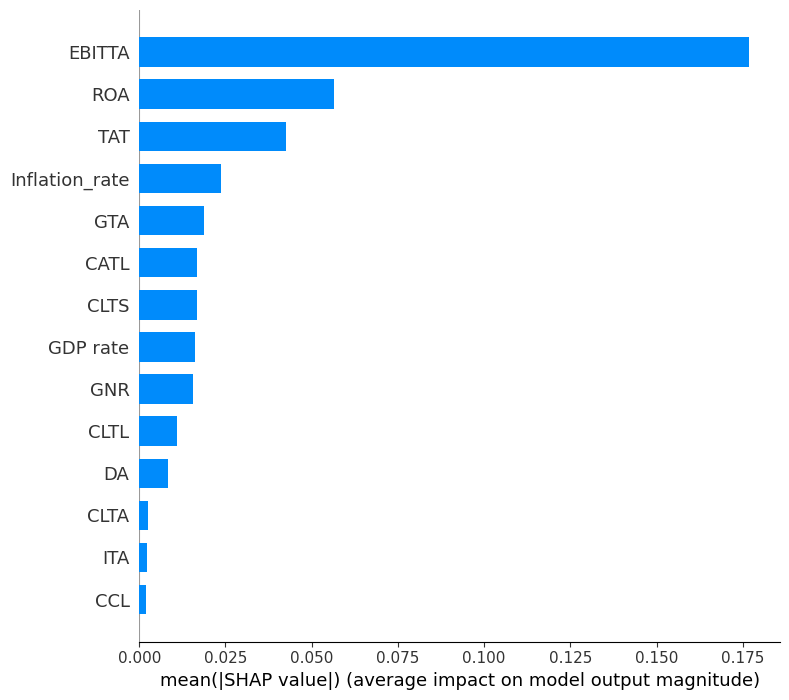

In [53]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train, 
                  features = X_train.values,
                  feature_names = X_train.columns.values,
                  plot_type='bar',
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

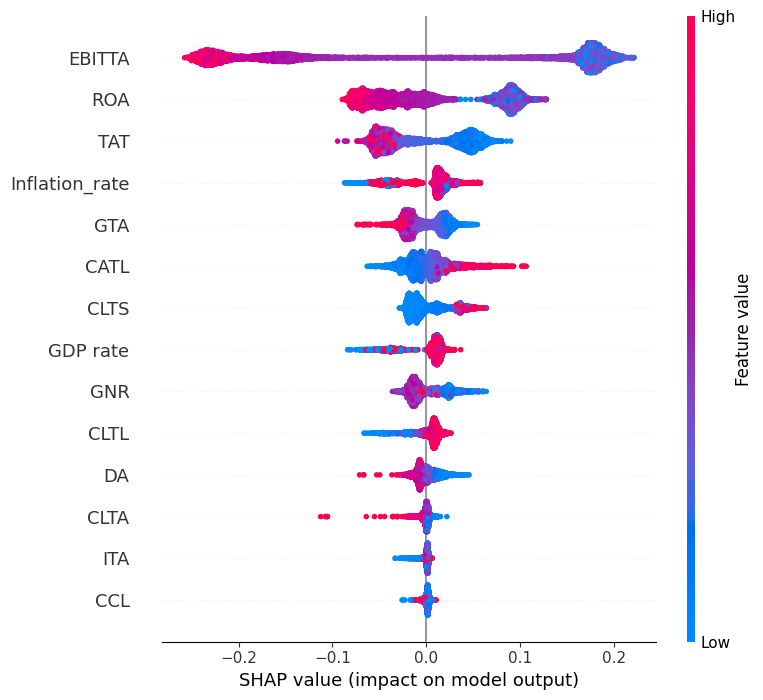

In [56]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values = shapley_values_train, 
                  features = X_resampled,
                  feature_names = X_train.columns.values,
                  max_display=15,
                  show=False)
plt.tight_layout()
plt.show()

Phân tích SHAP của mô hình dự đoán kiệt quệ tài chính đã xác định 10 biến số có ảnh hưởng lớn nhất, được sắp xếp theo mức độ quan trọng giảm dần trong biểu đồ. Phân tích này không chỉ xác định mức độ quan trọng mà còn làm rõ hướng tác động (tích cực hay tiêu cực) và mối quan hệ phi tuyến tính giữa giá trị của biến số (màu sắc) và đóng góp của nó vào dự đoán (giá trị SHAP).

Tỷ suất sinh lời

- EBITTA: EBITTA là biến quan trọng hàng đầu. Biểu đồ cho thấy sự phân tách rõ rệt: Các quan sát có EBITTA thấp (màu xanh) tập trung chụm ở vùng giá trị SHAP dương, cho thấy thiếu hụt lợi nhuận hoạt động là nguyên nhân trực tiếp và mạnh mẽ nhất làm tăng xác suất kiệt quệ tài chính. Ngược lại, EBITTA cao (màu đỏ) tạo ra giá trị SHAP âm (giảm mạnh nguy cơ). Điều này khẳng định vai trò cốt lõi của việc tạo ra lợi nhuận từ hoạt động kinh doanh chính trong việc duy trì ổn định tài chính, đặc biệt trong ngành sản xuất.

- ROA: ROA thấp (màu xanh) tập trung ở phía SHAP dương, chỉ ra rằng doanh nghiệp không khai thác tài sản hiệu quả để tạo ra lợi nhuận ròng, dẫn đến tăng nguy cơ kiệt quệ tài chính. ROA cao (màu đỏ) tập trung ở phía SHAP âm. Khả năng sinh lời trên tài sản càng kém thì nguy cơ kiệt quệ càng cao.

- TAT: TAT đo lường hiệu suất tài sản trong việc tạo ra doanh thu. TAT thấp (màu xanh) làm tăng nguy cơ kiệt quệ (SHAP dương), xác nhận rằng việc sử dụng tài sản kém hiệu quả trong việc tạo ra doanh thu bán hàng là một dấu hiệu thất bại hoạt động. Đây là chỉ số quan trọng bổ sung cho ROA, tập trung vào vòng quay và tốc độ hoạt động của doanh nghiệp

Tỷ lệ thanh khoản

- CATL: Trái ngược với kỳ vọng thanh khoản thông thường, CATL cao (màu đỏ) lại có xu hướng tạo ra SHAP dương mạnh mẽ. CATL cao làm tăng xác suất kiệt quệ tài chính (SHAP dương). Điều này có thể được lý giải là do CATL cao trong ngành sản xuất thường đi kèm với quản lý vốn lưu động kém hiệu quả (ví dụ: tồn kho dư thừa, tài sản ngắn hạn chất lượng kém hoặc bị mắc kẹt), làm giảm hiệu suất sử dụng vốn và gia tăng rủi ro tài chính.

- CLTS: CLTS cao (màu đỏ) (tức là doanh nghiệp gánh quá nhiều nợ ngắn hạn so với quy mô doanh thu) cho thấy áp lực tài trợ vốn lưu động lớn, đặc biệt đối với doanh nghiệp sản xuất. Điều này tạo ra SHAP dương, làm tăng nguy cơ vỡ nợ ngắn hạn do dòng tiền từ hoạt động kinh doanh không đủ để đáp ứng các khoản nợ đáo hạn.

- CLTL: CLTL tập trung vào cơ cấu nợ. Tỷ lệ cao (màu đỏ) của nợ ngắn hạn trong tổng nợ làm tăng nguy cơ kiệt quệ (SHAP dương). Tỷ lệ CLTL cao (màu đỏ) chỉ ra rằng nợ ngắn hạn chiếm tỷ trọng lớn trong cơ cấu nợ tổng thể. Nợ ngắn hạn đòi hỏi tái cấp vốn thường xuyên hơn, làm tăng rủi ro tái cấp vốn và sự nhạy cảm với lãi suất, dẫn đến SHAP dương (tăng nguy cơ kiệt quệ).

Các Yếu Tố Kinh tế Vĩ mô
- Inflation_rate: Lạm phát cao (màu đỏ) có xu hướng tạo ra SHAP dương, làm tăng nguy cơ kiệt quệ. Trong ngành sản xuất, lạm phát làm tăng chi phí đầu vào, siết chặt biên lợi nhuận và làm giảm hiệu quả hoạt động (EBITTA, ROA), qua đó gián tiếp thúc đẩy rủi ro tài chính.

- GDP rate: Tăng trưởng GDP cao (màu đỏ) có xu hướng tạo ra SHAP âm nhẹ. Điều này cho thấy môi trường kinh tế vĩ mô thuận lợi (GDP tăng trưởng tốt) đóng vai trò là yếu tố bảo vệ tổng thể, giúp giảm bớt nguy cơ kiệt quệ do nhu cầu thị trường tăng và môi trường kinh doanh ổn định hơn. Ngược lại, GDP rate thấp làm tăng rủi ro.

Tỷ lệ tăng trưởng:
- GTA: Tăng trưởng tổng tài sản càng thấp thì có xu hướng tạo ra SHAP dương. Điều này nói lên rằng sự trì trệ hoặc suy giảm quy mô tài sản (thể hiện qua tăng trưởng thấp) là một dấu hiệu của doanh nghiệp thiếu khả năng cạnh tranh, đầu tư, hoặc đang thu hẹp hoạt động, qua đó làm tăng nguy cơ kiệt quệ. Ngược lại, tốc độ tăng trưởng tài sản cao (màu đỏ) thường tạo ra SHAP âm (giảm nguy cơ).



In [41]:
joblib.dump(best_rf_model, "best_rf_model.pkl")

['best_rf_model.pkl']

## Voting

In [76]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
]

pipeline = Pipeline(steps=steps)

# --- Lưới tham số ---
param_grid_xgb = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__learning_rate": [0.01, 0.05, 0.1]
}
# --- GridSearchCV ---
grid_xgb = GridSearchCV(
    pipeline,
    param_grid=param_grid_xgb,
    scoring=make_scorer(fbeta_score, beta=2), 
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

# --- Kết quả ---
print("Best params:", grid_xgb.best_params_)
print("Best CV Recall:", round(grid_xgb.best_score_, 4))

# --- Mô hình tốt nhất ---
best_xgb_model = grid_xgb.best_estimator_

# --- Dự đoán trên tập test ---
y_pred_xgb = best_xgb_model.predict(X_test)

# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm.ravel()

# --- Đánh giá ---
metrics_xgb = {
    'Recall': round(recall_score(y_test, y_pred_xgb), 4),
    'Precision': round(precision_score(y_test, y_pred_xgb), 4),
    'F1-Score': round(f1_score(y_test, y_pred_xgb), 4),
    'Accuracy': round(accuracy_score(y_test, y_pred_xgb), 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_pred_xgb), 4),
    'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
}

metrics_results_xgb = pd.DataFrame([metrics_xgb])
print("\nHiệu suất mô hình XGBoost tốt nhất:")
print(metrics_results_xgb)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best CV Recall: 0.6164

Hiệu suất mô hình XGBoost tốt nhất:
   Recall  Precision  F1-Score  Accuracy  ROC-AUC   TN   FP  FN   TP
0    0.79       0.32      0.45      0.73     0.75  938  369  46  170


In [65]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
]
pipeline = Pipeline(steps=steps)

# Lưới tham số
param_grid_lr1 = [
    {
        'classifier__solver': ['lbfgs'], 
        'classifier__penalty': ['l2'], 
        'classifier__C': [0.01, 0.1, 0.5, 1, 10, 100],
        'classifier__max_iter': [25, 50, 100, 150, 200]
    },
    {
        'classifier__solver': ['liblinear'], 
        'classifier__penalty': ['l1', 'l2'], 
        'classifier__C': [0.01, 0.1, 0.5, 1, 10, 100],
        'classifier__max_iter': [25, 50, 100, 150, 200]
    },
    {
        'classifier__solver': ['saga'], 
        'classifier__penalty': ['l1', 'l2', 'elasticnet'], 
        'classifier__C': [0.01, 0.1, 0.5, 1, 10, 100],
        'classifier__max_iter': [25, 50, 100, 150, 200],
        'classifier__l1_ratio': [0.3, 0.5, 0.7]
    }
]

# GridSearchCV
grid_search_lr1 = GridSearchCV(
    pipeline,
    param_grid=param_grid_lr1,
    scoring='recall',  
    cv=5,
    n_jobs=-1
)

grid_search_lr1.fit(X_train, y_train)

print("Best params:", grid_search_lr1.best_params_)
print("Best CV recall:", grid_search_lr1.best_score_)

# Mô hình tốt nhất
best_model_lr1 = grid_search_lr1.best_estimator_

# Dự đoán trên test
y_pred_lr1 = best_model_lr1.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr1)
tn, fp, fn, tp = cm_lr.ravel()

metrics_lr1 = {
    'Recall' : recall_score(y_test, y_pred_lr1),
    'Precision' : precision_score(y_test, y_pred_lr1),
    'F1-Score' : f1_score(y_test, y_pred_lr1),
    'Accuracy' : accuracy_score(y_test, y_pred_lr1),
    'ROC-AUC' : roc_auc_score(y_test, y_pred_lr1),
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp
}

metrics_results_lr1 = pd.DataFrame([metrics_lr1])
print(metrics_results_lr1)

Best params: {'classifier__C': 0.01, 'classifier__max_iter': 25, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best CV recall: 0.8877520537714713
   Recall  Precision  F1-Score  Accuracy  ROC-AUC   TN   FP  FN   TP
0    0.86       0.27      0.41      0.64     0.73  792  515  30  186


In [70]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))
]

pipeline = Pipeline(steps=steps)

param_grid_svc = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__degree': [2, 3, 4], 
}

grid_search_svc = GridSearchCV(
    pipeline,
    param_grid=param_grid_svc,
    scoring='recall',  
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search_svc.fit(X_train, y_train)

print("Best Params:", grid_search_svc.best_params_)
print("Best CV Recall:", round(grid_search_svc.best_score_, 4))

best_svc = grid_search_svc.best_estimator_

y_pred_svc = best_svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred_svc)
tn, fp, fn, tp = cm.ravel()

metrics_svc = {
    'Recall': round(recall_score(y_test, y_pred_svc), 4),
    'Precision': round(precision_score(y_test, y_pred_svc), 4),
    'F1-Score': round(f1_score(y_test, y_pred_svc), 4),
    'Accuracy': round(accuracy_score(y_test, y_pred_svc), 4),
    'ROC-AUC': round(roc_auc_score(y_test, y_pred_svc), 4),
    'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
}

results_svc = pd.DataFrame([metrics_svc])
print("\nHiệu suất mô hình SVC tốt nhất:")
print(results_svc)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'classifier__C': 0.1, 'classifier__degree': 4, 'classifier__gamma': 'auto', 'classifier__kernel': 'poly'}
Best CV Recall: 0.9691

Hiệu suất mô hình SVC tốt nhất:
   Recall  Precision  F1-Score  Accuracy  ROC-AUC  TN    FP  FN   TP
0    0.97       0.14      0.25      0.18     0.51  58  1249   6  210


In [ ]:
steps = [
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', MLPClassifier(max_iter=500, random_state=42))
]

pipeline = Pipeline(steps=steps)

In [66]:
# Base pipelines (resampler + estimator)
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42))
])

xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('clf', XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 100, random_state=42))
])

mlp_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('clf', MLPClassifier(random_state=42))
])

svc_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('clf', SVC(probability=True, random_state=42))
])

lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTEENN(random_state=42)),
    ('clf', LogisticRegression(max_iter=25, penalty='l1', C= 0.01, solver='liblinear', random_state=42))
])


# Voting: using calibrated estimators' predict_proba via wrappers
voting = VotingClassifier(
    estimators=[('rf', rf_pipe), ('xgb', xgb_pipe), ('mlp', mlp_pipe), ('svc', svc_pipe), ('lr', lr_pipe)],
    voting='soft'
)

voting_cal = CalibratedClassifierCV(voting, method='sigmoid', cv=5) 
voting_cal.fit(X_train, y_train)
# voting.fit(X_train, y_train)


# Evaluate
proba_test = voting_cal.predict_proba(X_test)[:,1]
y_pred = (proba_test >= 0.1).astype(int) 

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Type I & II errors
type_I_error = fp / (fp + tn) if (fp + tn) > 0 else 0
type_II_error = fn / (fn + tp) if (fn + tp) > 0 else 0


voting_metrics = {
    'Recall' : recall_score(y_test, y_pred),
    'Precision' : precision_score(y_test, y_pred),
    'F1-Score' : f1_score(y_test, y_pred),
    'Accuracy' : accuracy_score(y_test, y_pred),
    'ROC-AUC' : roc_auc_score(y_test, proba_test),
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp,
    'Type I Error': type_I_error,
    'Type II Error': type_II_error
}

In [68]:
voting_results = pd.DataFrame([voting_metrics])
voting_results

,Recall,Precision,F1-Score,Accuracy,ROC-AUC,TN,FP,FN,TP,Type I Error,Type II Error
0,0.78,0.34,0.47,0.75,0.83,972,335,47,169,0.26,0.22


In [69]:
# Tạo bộ resampler
resampler = SMOTEENN(random_state=42)

# Base models
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)
xg = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 100, random_state=42)
svc = SVC(random_state=42)
mlp = MLPClassifier(random_state=42)

# Meta-model
meta_clf = LogisticRegression(random_state=42)

# Stacking classifier (chỉ bao gồm các base learners)
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('gb', xg), ('svc', svc), ('mlp', mlp)],
    final_estimator=meta_clf
)

# Gộp vào pipeline cùng SMOTEENN
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('classifier', stacking_clf)
])

# Huấn luyện mô hình
stacking_pipeline.fit(X_train, y_train)

# Dự đoán
y_pred = stacking_pipeline.predict(X_test)

# Đánh giá
print(recall_score(y_test, y_pred))

0.6620370370370371


In [ ]:
# Lưu mô hình đã huấn luyện
joblib.dump(voting, "voting_model.pkl")

In [ ]:
df_filtered.columns

In [ ]:
# df.to_csv(r'C:\Users\user\Documents\python\DADM\BCTC_2015_2023_cleaned.csv', index=False, encoding='utf-8-sig')